# Data visualization around the Grenoble 2020 elections - followers

## Loading the data

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
names = {
    'EricPiolle': 'Éric Piolle',
    'EmilieCChalas': 'Emilie Chalas',
    'CarignonAlain': 'Alain Carignon',
    'onoblecourt': 'Olivier Noblecourt',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}
colors2 = {names[n]: colors[users[n]] for n in names}

In [3]:
filenames = [
    'followers/CarignonAlain.csv',
    'followers/EmilieCChalas.csv',
    'followers/onoblecourt.csv',
    'followers/EricPiolle.csv',
]

data = []
for f in filenames:
    login = f.split('/')[1].split('.')[0]
    tmp = pandas.read_csv(f)
    tmp['candidate_login'] = login
    tmp['candidate_name'] = names[login]
    tmp['candidate_tag'] = users[login]
    data.append(tmp)
df = pandas.concat(data)
df['date'] = pandas.to_datetime(df['date'])

print(len(df), len(df.columns))

50042 18


In [4]:
df.groupby('candidate_name')[['date']].agg(['min', 'max', 'count'])

date                           
                                   min                 max  count
candidate_name                                                   
Alain Carignon     2007-06-27 08:32:25 2020-02-24 09:12:58   2802
Emilie Chalas      2007-05-14 23:16:29 2020-02-27 15:15:41   6762
Olivier Noblecourt 2006-12-08 15:00:33 2020-02-24 09:12:58   5858
Éric Piolle        2006-12-08 07:58:42 2020-02-27 20:40:58  34620

## Partage de followers

In [5]:
tmp = []
for c1 in df['candidate_name'].unique():
    for c2 in df['candidate_name'].unique():
        nb = len(set(df[df['candidate_name'] == c1]['id']) & set(df[df['candidate_name'] == c2]['id']))
        percent = nb/len(df[df['candidate_name'] == c1]) * 100
        txt = f'{percent:.1f} %' if percent < 100 else ''
        if c1 == c2:
            nb = 0
            percent = 0
        tmp.append({
            'candidate': c1,
            'other': c2,
            'nb_common': nb,
            'percent_shared': percent,
            'text': txt
        })
shared_followers = pandas.DataFrame(tmp)
shared_followers

,candidate,other,nb_common,percent_shared,text
0,Alain Carignon,Alain Carignon,0,0.000000,
1,Alain Carignon,Emilie Chalas,483,17.237687,17.2 %
2,Alain Carignon,Olivier Noblecourt,322,11.491792,11.5 %
3,Alain Carignon,Éric Piolle,844,30.121342,30.1 %
4,Emilie Chalas,Alain Carignon,483,7.142857,7.1 %
5,Emilie Chalas,Emilie Chalas,0,0.000000,
6,Emilie Chalas,Olivier Noblecourt,820,12.126590,12.1 %
7,Emilie Chalas,Éric Piolle,1193,17.642709,17.6 %
8,Olivier Noblecourt,Alain Carignon,322,5.496757,5.5 %
9,Olivier Noblecourt,Emilie Chalas,820,13.997952,14.0 %


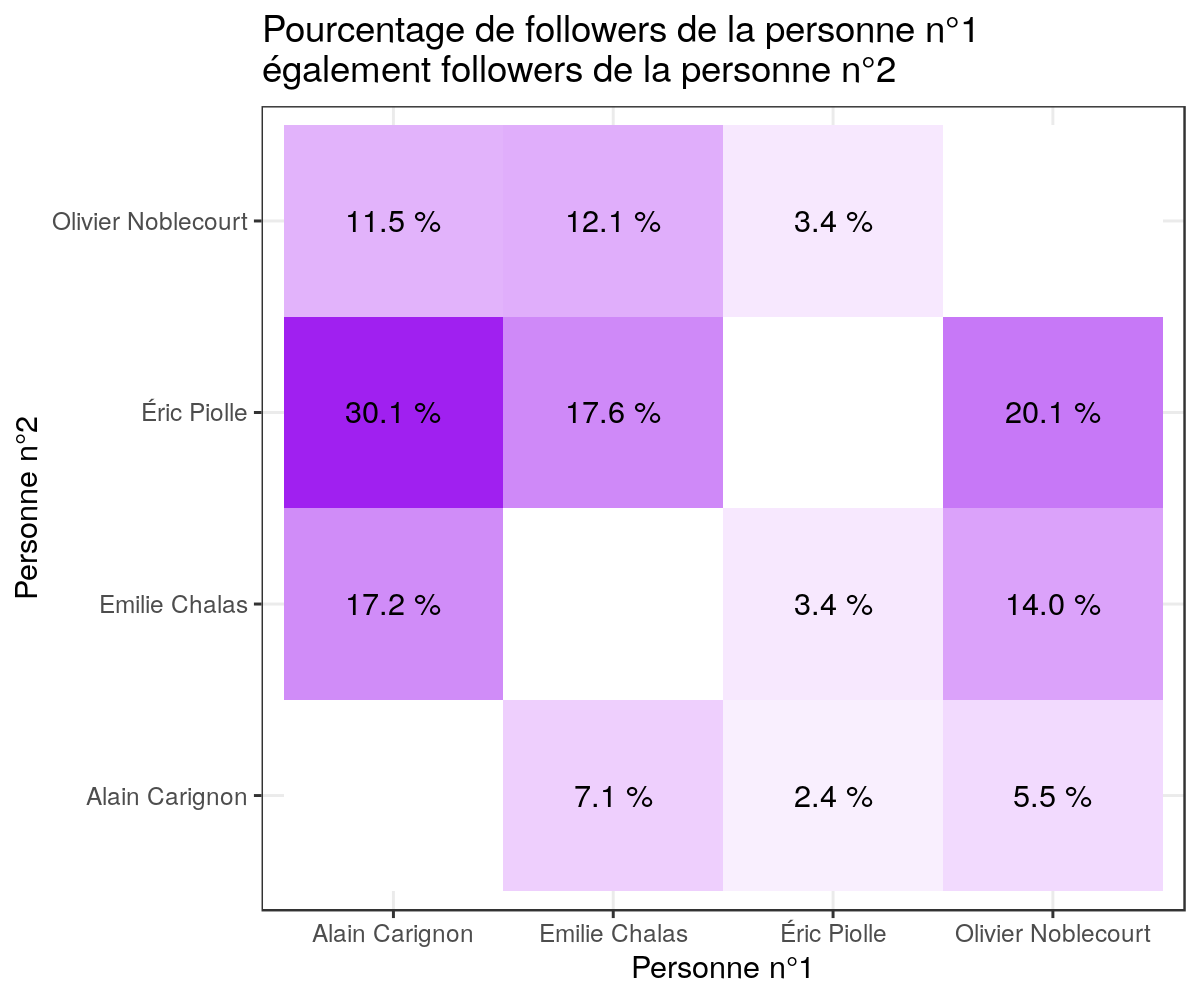

In [6]:
%%R -i shared_followers -w 6 -h 5 --units in -r 200

library(ggplot2)

plot = ggplot(shared_followers) +
    aes(x=candidate, y=other, fill=percent_shared) +
    geom_tile() +
    theme_bw() +
    scale_fill_gradient2(high = "purple") +
    geom_text(aes(label = text), color = "black") +
    xlab('Personne n°1') +
    ylab('Personne n°2') +
    theme(legend.position='none') +
    ggtitle('Pourcentage de followers de la personne n°1\négalement followers de la personne n°2')
#ggsave('/tmp/shared_followers.png', plot, width=6, height=5)
plot

In [7]:
df.columns

Index(['name', 'screen_name', 'date', 'description', 'followers_count',
       'following_count', 'statuses_count', 'likes_count',
       'default_background', 'default_avatar', 'verified', 'listed_count',
       'protected', 'id', 'location', 'candidate_login', 'candidate_name',
       'candidate_tag'],
      dtype='object')

## Localisation

In [8]:
import re

def count_locations(df, locations):
    df = df.copy()
    df.loc[df['location'].isna(), 'location'] = 'no_location'
    result = []
    for login in df['candidate_login'].unique():
        tmp = df[df['candidate_login'] == login]
        for loc in locations:
            loc = '|'.join(loc)
            nb_loc = len(tmp['location'].str.extractall(r'(?P<ville>%s)' % loc, re.IGNORECASE))
            nb_total = len(tmp)
            result.append({
                'login': login,
                'name': names[login],
                'tag': users[login],
                'location': loc,
                'count': nb_loc,
                'percent': nb_loc/nb_total*100,
            })
    result = pandas.DataFrame(result)
    return result

locations = count_locations(df, [['Grenoble'], ['Paris']])
others = count_locations(df, [['Nantes', 'Rennes', 'Bordeaux', 'Strasbourg', 'Toulouse', 'Marseille', 'Montpellier', 'Nice', 'Lyon']])
others['location'] = 'Autres grandes villes FR'
noloc = count_locations(df, [['no_location']])
noloc['location'] = 'Non spécifiée'
locations = pandas.concat([locations, others, noloc])

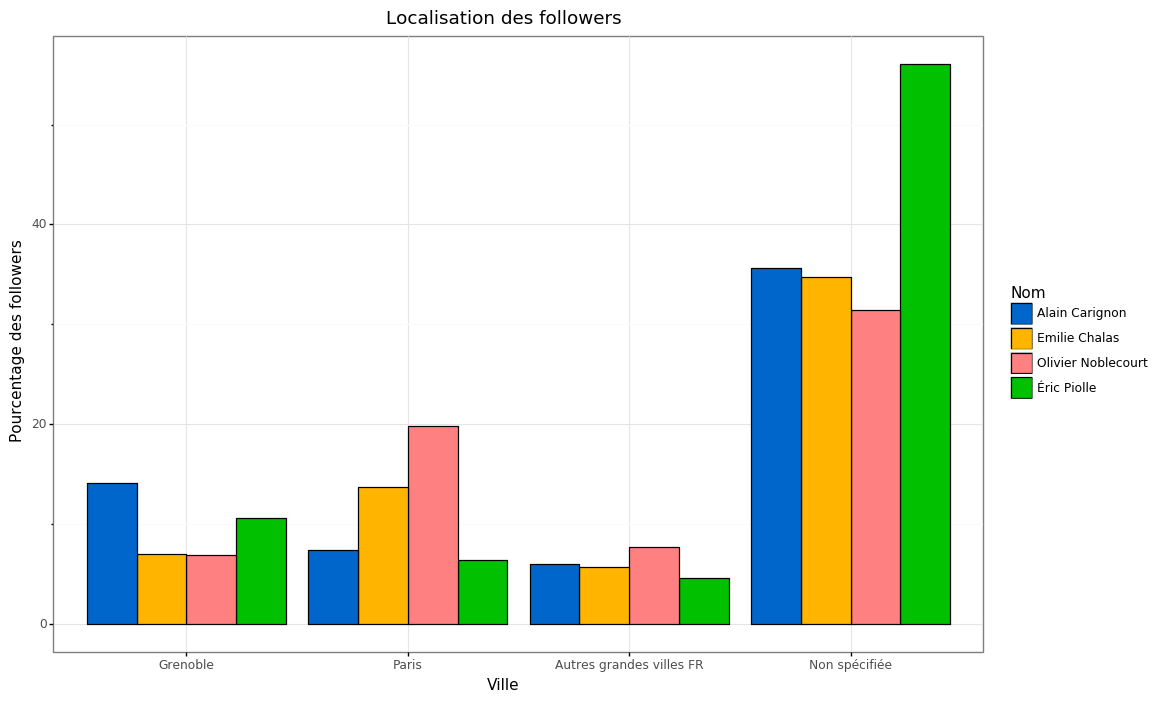

<ggplot: (8743555702918)>

In [9]:
ggplot(locations) +\
    aes(x='location', y='percent', group='name') +\
    geom_bar(aes(fill='name', group='name'), stat='identity', color='black', position='dodge') +\
    theme_bw() +\
    scale_fill_manual(colors2) +\
    ylab('Pourcentage des followers') +\
    xlab('Ville') +\
    labs(fill='Nom') +\
    scale_x_discrete(limits=['Grenoble', 'Paris', 'Autres grandes villes FR', 'Non spécifiée']) +\
    ggtitle('Localisation des followers')